# Estabilizando rede neurais - Batch Normalization

### Problemas com redes profundas

In [84]:
import matplotlib.pyplot as plt
import torch
from torch import nn

def conv3x3(in_channels, out_channels):
    """Cria camada convolucional com filtro de tamanho 3 e sem bias."""
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)

class Model(nn.Module):
    '''Modelo com `num_layers` camadas convolucionais, cada uma com `num_channels` canais.'''
    def __init__(self, num_layers, num_channels):
        super().__init__()
        
        layers = [
            conv3x3(1,num_channels),
            nn.ReLU()
        ]
        for idx in range(1, num_layers):
            layers.append(conv3x3(num_channels,num_channels))
            layers.append(nn.ReLU())
        self.layers = nn.ModuleList(layers)

        self.pool = nn.AdaptiveMaxPool2d(1)
        # Camada linear que recebe entrada de tamanho features e gera 10 valores de saída
        self.fc = nn.Linear(num_channels, 10)

    def forward(self, x):
        '''Além de calcular o resultado, este método retorna as ativações
        inermediárias da rede.'''
        acts = []
        for layer in self.layers:
            x = layer(x)
            acts.append(x)
        x = self.pool(x)
        # Transformação das imagens de tamanho bs x features x 1 x 1 para bs x features
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x, acts
    
model = Model(10, 16)
# Desabilita cálculo de gradientes, pois não será usado neste notebook
model.requires_grad_(False)
model

Model(
  (layers): ModuleList(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): ReLU()
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU()
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU()
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): ReLU()
    (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): ReLU()
    (14): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): ReLU()
    (16): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (17): ReLU()
    (18): Conv2d(16, 16, kernel_siz

Execute a célula abaixo diversas vezes com ctrl+enter. A saída da rede é sempre a mesma!

In [88]:
x = torch.rand(1, 1, 28, 28)
y, acts = model(x)

print(x[0,0,0])
print(y)

tensor([0.4220, 0.6534, 0.7058, 0.6141, 0.0039, 0.4058, 0.2153, 0.7416, 0.2496,
        0.1170, 0.1126, 0.2317, 0.9601, 0.0256, 0.7503, 0.1529, 0.6428, 0.6843,
        0.6159, 0.5975, 0.4896, 0.4839, 0.2952, 0.7940, 0.4450, 0.9760, 0.1053,
        0.2103])
tensor([[ 0.1559, -0.1548,  0.0650,  0.2148,  0.1309, -0.1858, -0.0467, -0.2276,
          0.1771,  0.0676]])


A saída da rede é dada apenas pelo bias da última camada:

In [89]:
print(y)
print(model.fc.bias)

tensor([[ 0.1559, -0.1548,  0.0650,  0.2148,  0.1309, -0.1858, -0.0467, -0.2276,
          0.1771,  0.0676]])
Parameter containing:
tensor([ 0.1559, -0.1548,  0.0650,  0.2149,  0.1309, -0.1859, -0.0467, -0.2276,
         0.1771,  0.0676])


Plotando a média e desvio padrão das ativações intermediárias da rede, vemos que os valores caem para zero:

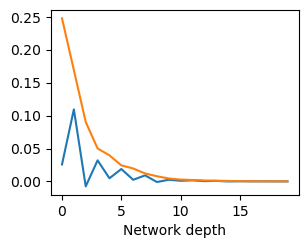

In [91]:
def show_activations(acts):
    act_mean = []
    act_std = []
    for act in acts:
        act = act.detach()
        act_mean.append(act.mean())
        act_std.append(act.std())

    plt.plot(act_mean)
    plt.plot(act_std)
    plt.xlabel('Network depth')

show_activations(acts)

Essencialmente, a operação que uma rede neural faz é dada por:

In [78]:
# Batch de dados
x = torch.rand(10)
# Parâmetros das camadas
weight = 2.
bias = 2.
# 100 camadas
for i in range(100):
    x = weight*x+bias
print(x)

tensor([2.5635e+30, 3.5656e+30, 3.0748e+30, 2.8878e+30, 2.8740e+30, 2.9175e+30,
        3.3621e+30, 2.8442e+30, 2.8549e+30, 3.7309e+30])


Tente achar valores de `weight` e `bias` que não levem o valor de x acima a 0, infinito ou algum valor trivial.

### Batch Normalization

Ao normalizarmos os valores, as ativações se tornam bem comportadas!

In [80]:
def normalization(x):
    mean = x.mean()
    std = x.std()
    return (x-mean)/std

x = torch.rand(10)
weight = 20.
bias = -10.
for i in range(10):
    x = weight*x+bias
    x = normalization(x)
print(x)

tensor([-1.2149, -1.3395,  0.0467, -0.9665, -0.2244, -0.5013,  1.2022,  0.8227,
         1.1350,  1.0399])


Mas e se a escala dos valores for relevante para a classificação? Por exemplo, talvez um filtro tenda a gerar valores em torno de 10, enquanto que outro filtro gere valores em torno de 0.1. Essa informação será perdida após a normalização.

Uma camada batchnorm permite reescalar os valores caso seja necessário. Os parâmetros de escala são aprendidos durante o treinamento.

In [102]:
class BatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        # nn.Parameter define um tensor com requires_grad=True e que é registrado 
        # como parâmetro treinável do modelo
        self.weight = nn.Parameter(torch.tensor(1.))
        self.bias = nn.Parameter(torch.tensor(0.))

        self.eps = 1e-5

    def forward(self, x):

        mean = x.mean()
        var = x.var()   # Variância
        # eps evita divisão por 0
        x_norm = (x-mean)/torch.sqrt(var+self.eps)

        # Reescala os valores
        y = self.weight*x_norm + self.bias

        return y
    
bn = BatchNorm()
bn(100*torch.rand(10))


tensor([-1.1120, -1.1633,  0.4794,  0.0345,  1.3023,  1.3419, -0.0373, -0.6873,
         0.9688, -1.1270], grad_fn=<AddBackward0>)

Mas temos um problema. E quando formos aplicar a rede após o treinamento em uma única imagem? Cada camada terá apenas uma única ativação, o que pode ser um problema. Para evitar isso, durante o treinamento podemos armazenar a média e desvio padrão de todos os batches, e usar a estimativa desses parâmetros de todos os batches para normalizar os valores ao aplicar em uma única imagem.

### Desvendando a camada BatchNorm do Pytorch

In [137]:
# Batchnorm aplicado em 3 canais
bn = nn.BatchNorm2d(3)
print(bn.weight)
print(bn.bias)

Parameter containing:
tensor([1., 1., 1.], requires_grad=True)
Parameter containing:
tensor([0., 0., 0.], requires_grad=True)


A longo de vários batches, a camada estima a média e variância dos dados:

In [138]:
# Cria batches artificiais possuindo 4 imagens cada. Cada imagem possui 3 canais
# e tamanho 256x256. Os valores das imagens são aleatórios com média 10 e
# desvio padrão 2
bs = 4
img_shape = (3, 256, 256)
batches = []
for idx in range(100):
    batch = torch.normal(mean=10, std=2, size=(bs,*img_shape))
    batches.append(batch)

for batch in batches:
    _ = bn(batch)
    print('mean', bn.running_mean, 'var', bn.running_var)



mean tensor([1.0003, 1.0002, 0.9999]) var tensor([1.3016, 1.2976, 1.3006])
mean tensor([1.8999, 1.9005, 1.9001]) var tensor([1.5697, 1.5666, 1.5704])
mean tensor([2.7098, 2.7099, 2.7097]) var tensor([1.8113, 1.8119, 1.8136])
mean tensor([3.4390, 3.4376, 3.4384]) var tensor([2.0307, 2.0309, 2.0338])
mean tensor([4.0950, 4.0944, 4.0948]) var tensor([2.2281, 2.2269, 2.2303])
mean tensor([4.6851, 4.6851, 4.6854]) var tensor([2.4032, 2.4070, 2.4085])
mean tensor([5.2161, 5.2166, 5.2168]) var tensor([2.5642, 2.5663, 2.5678])
mean tensor([5.6951, 5.6950, 5.6950]) var tensor([2.7064, 2.7101, 2.7087])
mean tensor([6.1253, 6.1257, 6.1257]) var tensor([2.8378, 2.8396, 2.8378])
mean tensor([6.5127, 6.5130, 6.5133]) var tensor([2.9543, 2.9557, 2.9542])
mean tensor([6.8616, 6.8622, 6.8619]) var tensor([3.0580, 3.0595, 3.0585])
mean tensor([7.1758, 7.1756, 7.1755]) var tensor([3.1517, 3.1532, 3.1525])
mean tensor([7.4583, 7.4579, 7.4582]) var tensor([3.2355, 3.2389, 3.2377])
mean tensor([7.7122, 7.71

Os valores de `running_mean` e `running_var` são utilizados para normalizar os dados. 

No modo eval, a média estimada é usada quando a camada for aplicada em novos dados:

In [141]:
# Imagem com média 15 e desvio padrão 2
x = torch.normal(mean=15, std=2, size=(1,3,256,256))
bn.eval()
y = bn(x)
# A média do resultado deve ser aproximadamente (15-bn.running_mean)/bn.running_var**0.5
print(y.mean())

tensor(2.4996, grad_fn=<MeanBackward0>)


Retornando o batchnorm para o modo .train faz com que a camada volte a normalizar pela média e desvio do batch:

In [142]:
bn.train()
y = bn(x)
print(y.mean())

tensor(3.1898e-08, grad_fn=<MeanBackward0>)
